AdaBoostClassifier 用于分类,算法SAMME和SAMME.R<br>

AdaBoostRegressor  用于回归,算法Adaboost.R2


### 调参步骤

1.对Adaboost框架进行调参<br>
2.对选择的弱分类器进行调参

## 框架参数解读（AdaBoostClassifier简称ABC,AdaBoostRegressor简称ABR）

#### base_estimator(选择弱学习器)：ABC&ABR都有。CART决策树（默认）或者神经网络MLP.
即AdaBoostClassifier默认使用CART分类树DecisionTreeClassifier，<br>
而AdaBoostRegressor默认使用CART回归树DecisionTreeRegressor。

ABC算法选的是SAMME.R，弱分类学习器还需要支持概率预测，即scikit-learn中弱分类学习器对应的预测方法除了predict还需要有predict_proba。

### algorithm(算法)：ABC。SAMME和SAMME.R。区别是弱学习器权重的度量

SAMME使用对样本集分类效果作为弱学习器权重<br>
SAMME.R使用对样本集分类的预测概率大小来作为弱学习器权重

由于SAMME.R使用了概率度量的连续值，迭代一般比SAMME快，因此AdaBoostClassifier的**默认算法**algorithm的值也是SAMME.R。<br>
我们一般使用默认的SAMME.R就够了，但是要注意的是使用了SAMME.R， 则弱分类学习器参数base_estimator必须限制使用支持概率预测的分类器。<br>
SAMME算法则没有这个限制。

### n_estimators：整数型，可选参数，默认为50。弱学习器的最大迭代次数，或者说最大的弱学习器的个数。

一般来说n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合。<br>
默认是50。在实际调参的过程中，常常将n_estimators和参数learning_rate一起考虑。

### learning_rate：浮点型，可选参数，默认为1.0。

每个弱学习器的权重缩减系数，取值范围为0到1，<br>
对于同样的训练集拟合效果，较小的v意味着我们需要更多的弱学习器的迭代次数。<br>
加上了正则化项的强学习器的迭代公式为：
$$f(x)=f_{k-1}(x)+v\alpha_kG_k(x)$$
ν 的取值范围为0<ν≤1。<br>
通常我们用步长和迭代最大次数一起来决定算法的拟合效果。所以这两个参数n_estimators和learning_rate要一起调参。<br>
从一个小一点的v开始调参，默认是1。

### loss：ABR

Adaboost.R2算法需要用到。<br>
有线性‘linear’, 平方‘square’和指数 ‘exponential’三种选择,<br>
默认是线性，一般使用线性就足够了

## AdaBoostClassifier和AdaBoostRegressor弱学习器参数

### max_features:划分时考虑的最大特征数，可以使用很多种类型的值：
默认是"None",意味着划分时考虑所有的特征数；<br>
如果是"log2"意味着划分时最多考虑log2N个特征；<br>
如果是"sqrt"或者"auto"意味着划分时最多考虑N−−√个特征。<br>
如果是整数，代表考虑的特征绝对数。<br>
如果是浮点数，代表考虑特征百分比，即考虑（百分比xN）取整后的特征数。其中N为样本总特征数。<br>
一般来说，如果样本特征数不多，比如小于50，我们用默认的"None"就可以了，如果特征数非常多，我们可以灵活使用刚才描述的其他取值来控制划分时考虑的最大特征数，以控制决策树的生成时间。

### 决策树最大深max_depth: 默认可以不输入，

如果不输入的话，决策树在建立子树的时候不会限制子树的深度。
一般来说，数据少或者特征少的时候可以不管这个值。如果模型样本量多，特征也多的情况下，推荐限制这个最大深度，具体的取值取决于数据的分布。常用的可以取值10-100之间。

### min_samples_split: 内部节点再划分所需最小样本数
这个值限制了子树继续划分的条件，如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分。 默认是2.如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。

### min_samples_leaf: 叶子节点最少样本数
这个值限制了叶子节点最少的样本数，
如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。 默认是1,可以输入最少的样本数的整数，或者最少样本数占样本总数的百分比。如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。

### min_weight_fraction_leaf：叶子节点最小的样本权重和
这个值限制了叶子节点所有样本权重和的最小值，如果小于这个值，则会和兄弟节点一起被剪枝。 默认是0，就是不考虑权重问题。一般来说，如果我们有较多样本有缺失值，或者分类树样本的分布类别偏差很大，就会引入样本权重，这时我们就要注意这个值了。

### max_leaf_nodes: 最大叶子节点数
通过限制最大叶子节点数，可以防止过拟合，默认是"None”，即不限制最大的叶子节点数。如果加了限制，算法会建立在最大叶子节点数内最优的决策树。如果特征不多，可以不考虑这个值，但是如果特征分成多的话，可以加以限制，具体的值可以通过交叉验证得到。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

In [2]:
# 生成2维正态分布，生成的数据按分位数分为两类，500个样本,2个样本特征，协方差系数为2
X1, y1 = make_gaussian_quantiles(cov=2.0,
                                 n_samples=500, 
                                 n_features=2,
                                 n_classes=2, 
                                 random_state=1)

In [6]:
# 生成2维正态分布，生成的数据按分位数分为两类，400个样本,2个样本特征均值都为3，协方差系数为2
X2, y2 = make_gaussian_quantiles(mean=(3, 3), 
                                 cov=1.5,
                                 n_samples=400,
                                 n_features=2, 
                                 n_classes=2, 
                                 random_state=1)

In [7]:
#讲两组数据合成一组数据
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

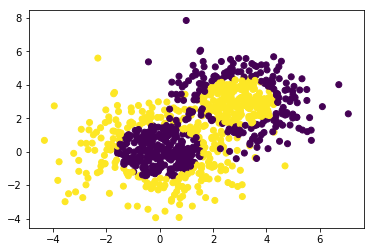

In [8]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

In [9]:
# 用基于决策树的Adaboost来做分类拟合。
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, 
                                                min_samples_split=20, 
                                                min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=200, 
                         learning_rate=0.8)

In [10]:
bdt.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.8, n_estimators=200, random_state=None)

In [11]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

In [13]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))#步长0.02

'''
二维坐标系中,X轴可以取三个值1,2,3, Y轴可以取三个值7,8, 请问可以获得多少个点的坐标?
显而易见是6个:
(1,7)(2,7)(3,7)
(1,8)(2,8)(3,8)
'''

'\n二维坐标系中,X轴可以取三个值1,2,3, Y轴可以取三个值7,8, 请问可以获得多少个点的坐标?\n显而易见是6个:\n(1,7)(2,7)(3,7)\n(1,8)(2,8)(3,8)\n'

In [16]:
Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

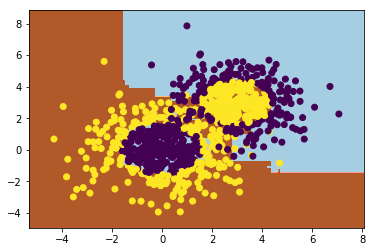

In [17]:
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
plt.show()

In [18]:
print ("Score:", bdt.score(X,y))

Score: 0.9133333333333333


In [19]:
# 把分数从200增加到300
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, 
                                                min_samples_split=20, 
                                                min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=300, 
                         learning_rate=0.8)
bdt.fit(X, y)
print ("Score:", bdt.score(X,y))

Score: 0.9622222222222222


In [20]:
# 将步长从上面的0.8减少到0.5

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, 
                                                min_samples_split=20, 
                                                min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=300, 
                         learning_rate=0.5)
bdt.fit(X, y)
print ("Score:", bdt.score(X,y))

Score: 0.8944444444444445


In [21]:
# 最后我们看看当弱分类器个数为700，步长为0.7时候的情况：

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, 
                                                min_samples_split=20, 
                                                min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=600, 
                         learning_rate=0.7)
bdt.fit(X, y)
print ("Score:", bdt.score(X,y))

Score: 0.9611111111111111


In [22]:
# 300弱分类器，0.8步长的拟合程度相当。也就是说，在我们这个例子中，如果步长从0.8降到0.7，则弱分类器个数要从300增加到700才能达到类似的拟合效果。